# **WCGAN**

In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()

2025-05-03 10:04:37.105789: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746266677.278464      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746266677.329083      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import pandas as pd
import keras as keras
from tensorflow import keras
from tensorflow.keras import Sequential,layers
from tensorflow.keras.layers import Dense , Flatten, UpSampling2D, Conv2D, Dropout, LeakyReLU
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras.utils import to_categorical
from keras.datasets import fashion_mnist
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import os
import re
import warnings

import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.src import backend
from keras.src.api_export import keras_export
from keras.src.callbacks.callback import Callback
from keras.src.utils import file_utils
from keras.src.utils import io_utils
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization
from keras.models import Sequential

In [ ]:
ds = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = ds.load_data() 
batch_size = 128
latent_dim = 128

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
def scale_images(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    train_norm = (train_norm - 127.5) / 127.5
    test_norm = (test_norm - 127.5) / 127.5
    return train_norm, test_norm

x_train, x_test = scale_images(x_train, x_test)
np.random.shuffle(x_train)

In [ ]:
def build_generator():
  model = Sequential()

  #toma valores random y los convierte en 7x7x128 - comienzo de generación de imágenes
  model.add(Dense(7*7*128, input_dim=128))  #para convertir los 128 valores random en imagenes de 7x7 (darles algo de dimensión espacial)
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(layers.Reshape((7, 7, 128)))

  model.add(Conv2DTranspose(128,4,strides=2, padding='same')) #128 unidades para preservar el número de canales
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())

  model.add(Conv2DTranspose(1,4,strides=2,padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))
  model.add(BatchNormalization())

  # podríamos parar si pusiéramos 1 unidad en vez de 128 aquí porque ya conseguiríamos 28x28x1 pero voy a seguir construyendo
  model.add(Conv2D(128, 4, padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(Conv2D(128,4,padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))

  model.add(Conv2D(128,4,padding='same'))
  model.add(layers.LeakyReLU(alpha=0.2))

  #capa convolucional para obtener 1 canal
  model.add(Conv2D(1, 4, padding='same',activation='tanh')) #1 kernel de tamaño 4x4, padding=same indica que mantendremos 28x28
  return model

In [6]:
generator = build_generator()
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746266696.878847      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │           2,049 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 1)           │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 128)         │           2,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,602,694 (6.11 MB)

 Trainable params: 1,602,436 (6.11 MB)

 Non-trainable params: 258 (1.01 KB)

In [ ]:
def display_images(generated_images):
    plt.figure(figsize=(10, 10))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

In [9]:
# Reduce el tamaño del crítico (demasiadas capas para Fashion-MNIST)
def build_critic():
    model = Sequential()
    # Capa 1
    model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=(28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    # Capa 2
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    # Capa 3
    model.add(Conv2D(256,(5,5),padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))
    
    # Capa final
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(1))
    return model

In [10]:
critic = build_critic()
critic.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 7, 7, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,038,593 (3.96 MB)

 Trainable params: 1,038,593 (3.96 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
def gradient_penalty(self, batch_size, real_images, fake_images):
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)  #genera un tensor de nºs aleatorios de tamaño (batch_sz,1,1,1) llamado alpha, a partir de una normal(0,1)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff  #creamos imágenes ficticias entre las reales y falsas, controlándo cuánta mezcla hay en cada interpolación con alpha

    with tf.GradientTape() as gp_tape:  #cálculo del gradiente
        gp_tape.watch(interpolated)
        pred = self.critic(interpolated, training=True) #obtiene la predicción del crítico

    grads = gp_tape.gradient(pred, [interpolated])[0]  #cálculo del gradiente de la prediccion vs interpolacion
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))  #norma L2 de los gradientes
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp  #la función devuelve la distancia entre la norma L2 Y 1 media al cuadrado

In [12]:
g_opt = Adam(0.00001, beta_1=0.0, beta_2=0.9)
c_opt = Adam(0.0001, beta_1=0.0, beta_2=0.9)


In [13]:
random_latent_vectors = tf.random.normal(shape=(batch_size, latent_dim))
fake_images = generator(random_latent_vectors, training = True)
fake_predictions = critic(fake_images, training = True)
real_images = x_train[:batch_size]
real_predictions = critic(real_images, training = True)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_train.shape,fake_images.shape, fake_predictions.shape, real_images.shape, real_predictions.shape, x_train.shape[0]

I0000 00:00:1746266698.412437      31 cuda_dnn.cc:529] Loaded cuDNN version 90300


((60000, 28, 28, 1),
 TensorShape([128, 28, 28, 1]),
 TensorShape([128, 1]),
 (128, 28, 28),
 TensorShape([128, 1]),
 60000)

In [14]:
alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)

In [ ]:
class FashionWGAN(Model):
    def __init__(self, generator, critic, latent_dim=128, batch_size=128, gp_weight=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.critic = critic
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.gp_weight = gp_weight

        self.c_loss_tracker = tf.keras.metrics.Mean(name="c_loss")
        self.c_wass_tracker = tf.keras.metrics.Mean(name="c_wass")
        self.c_gp_tracker = tf.keras.metrics.Mean(name="c_gp")
        self.g_loss_tracker = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_tracker,
            self.c_wass_tracker,
            self.c_gp_tracker,
            self.g_loss_tracker
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calcula la penalización del gradiente para WGAN-GP"""
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        interpolated = real_images + alpha * (fake_images - real_images)

        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)
        
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        
        gp = tf.reduce_mean((norm - 1.0)**2)
        return gp

    def compile(self, g_opt, c_opt, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.c_opt = c_opt

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        
        batch_size = tf.shape(real_images)[0]
        real_images = tf.cast(real_images, tf.float32)

        for _ in range(2):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            with tf.GradientTape() as tape:
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(real_predictions)
                c_gp = self.gradient_penalty(batch_size, real_images, fake_images)
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_grad = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_opt.apply_gradients(zip(c_grad, self.critic.trainable_variables))

        for _ in range(1):
           random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
           with tf.GradientTape() as tape:
              fake_images = self.generator(random_latent_vectors, training=True)
              fake_predictions = self.critic(fake_images, training=True)
              g_loss = -tf.reduce_mean(fake_predictions)

           g_grad = tape.gradient(g_loss, self.generator.trainable_variables)
           self.g_opt.apply_gradients(zip(g_grad, self.generator.trainable_variables))

        self.c_loss_tracker.update_state(c_loss)
        self.c_wass_tracker.update_state(c_wass_loss)
        self.c_gp_tracker.update_state(c_gp)
        self.g_loss_tracker.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}

In [16]:
redFASHIONWGAN = FashionWGAN(generator, critic)

In [ ]:
dummy_input = tf.random.normal([1, 128]) 
dummy_image = tf.random.normal([1, 28, 28, 1])  

_ = generator(dummy_input)
_ = critic(dummy_image)


In [18]:
redFASHIONWGAN.compile(g_opt,c_opt)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

carpeta = "resultados"

if not os.path.exists(carpeta):
    os.makedirs(carpeta)

print(f"Carpeta '{carpeta}' creada o ya existente.")


Carpeta 'resultados' creada o ya existente.


In [ ]:
class ModelMonitor(Callback):                             #genera y guarda 3 imágenes tras cada época
  def __init__(self,num_img=4, latent_dim=128, save_interval=10,output_dir='/kaggle/working/resultados'):
    self.num_img = num_img
    self.latent_dim = latent_dim
    self.save_interval = save_interval
    self.output_dir='/kaggle/working/resultados'

  def on_epoch_end(self, epoch, logs=None):
   if (epoch + 1) % self.save_interval == 0:
    random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim,1)) #genera 3 imágenes, cuyo espacio latente tenga dim=128 valores aleatorios
    generated_images = self.model.generator(random_latent_vectors) #pasa los valores de antes al generador
    generated_images *=255 #invertir el escalado
    generated_images.numpy() #convertimos el vector de imágenes en un vector numpy (formato típico de imágenes)
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('resultados', f'generated_img_{epoch}_{i}.png'))

cambiar gq_weight inicial de 10 a 1
meter betas en learning rate (alpha del c pasa de 0.00001 a 0.0001)
cambio el scale_image para solucionar el NaN
quito la activación tanh de generador y critico
le quito los bloques 1 y 4 al critico
Obtenia g_loss alrededor de 7 y c_loss alrededor de -0.1 (no generaba buenas imágenes)-->meto alpha de 0.00001 al critico y lo itero por 3 veces en vez de 5.
23/04 aumento la complejidad del generador y itero el critico solo 1 vez para ver si obtengo menos perdida en generador.
Ahora itero el generador 3 vecces en lugar del critico----> parece algo bueno pero tarda un poco.
Voy a aumentar la complejidad del generador--->no vale
Vuelvo a 2 o 3 training steps para el critic y 1 solo para el generador--->el generador sigue aprendiendo demasiado rápido (modo collapso)
Disminuyo la learning rate del  generador + dropout de critico de 0.4 a 0.3 + random noise en generador + capa convolucional en critico
Con 100 epocas tenemos un resultado que PARECE COMENZAR A ESTABILIZARSE según el gráfico de c_loss y g_loss. Las imágenes generadas no son las mejores pero vamos a meter 50 epocas más para comparar con el fashionMNIST y WGAN


Vamos a meter 150 epocas en vez de 100, a ver como varia el grafico y las imágenes

In [ ]:
history = redFASHIONWGAN.fit(x_train, epochs=200,callbacks = [ModelMonitor()],batch_size=128) #d_loss y g_loss deben equilibrarse

Epoch 1/200


I0000 00:00:1746266712.942134      92 service.cc:148] XLA service 0x7cafd401e740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746266712.942655      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/469 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - c_gp: 0.8093 - c_loss: 7.8853 - c_wass: -0.2081 - g_loss: -0.0136   

I0000 00:00:1746266734.203951      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


469/469 ━━━━━━━━━━━━━━━━━━━━ 94s 130ms/step - c_gp: 0.5009 - c_loss: -16.8430 - c_wass: -21.8520 - g_loss: -5.3029
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - c_gp: 0.0471 - c_loss: -4.5270 - c_wass: -4.9985 - g_loss: -9.4412
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - c_gp: 0.0519 - c_loss: -4.3981 - c_wass: -4.9169 - g_loss: -19.3568
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - c_gp: 0.0551 - c_loss: -4.4102 - c_wass: -4.9616 - g_loss: -15.3305
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - c_gp: 0.0567 - c_loss: -4.3506 - c_wass: -4.9173 - g_loss: -9.5752
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - c_gp: 0.0603 - c_loss: -4.3851 - c_wass: -4.9881 - g_loss: -3.6137
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - c_gp: 0.0646 - c_loss: -4.4677 - c_wass: -5.1133 - g_loss: 1.1362
Epoch 8/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 81ms/step - c_gp: 0.0669 - c_loss: -4.5366 - c_wass: -5.2056 - g_loss: 3.9834
Epoch 9/200
469/4

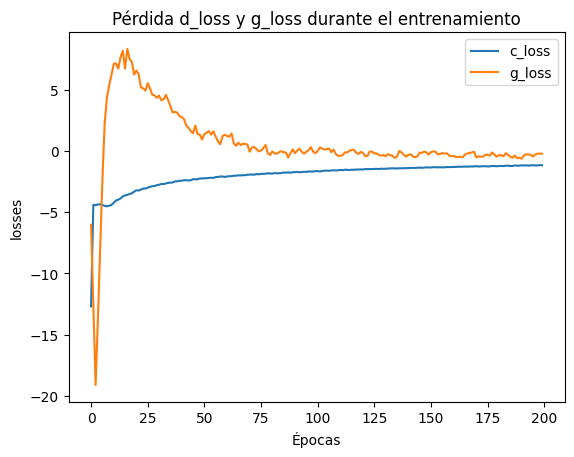

In [24]:
import matplotlib.pyplot as plt
d_loss_values = history.history['c_loss']
g_loss_values =history.history['g_loss']
s = history.history['g_loss']
plt.plot(d_loss_values, label='c_loss')
plt.plot(g_loss_values, label='g_loss')
plt.title('Pérdida d_loss y g_loss durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('losses')
plt.legend()
plt.show()

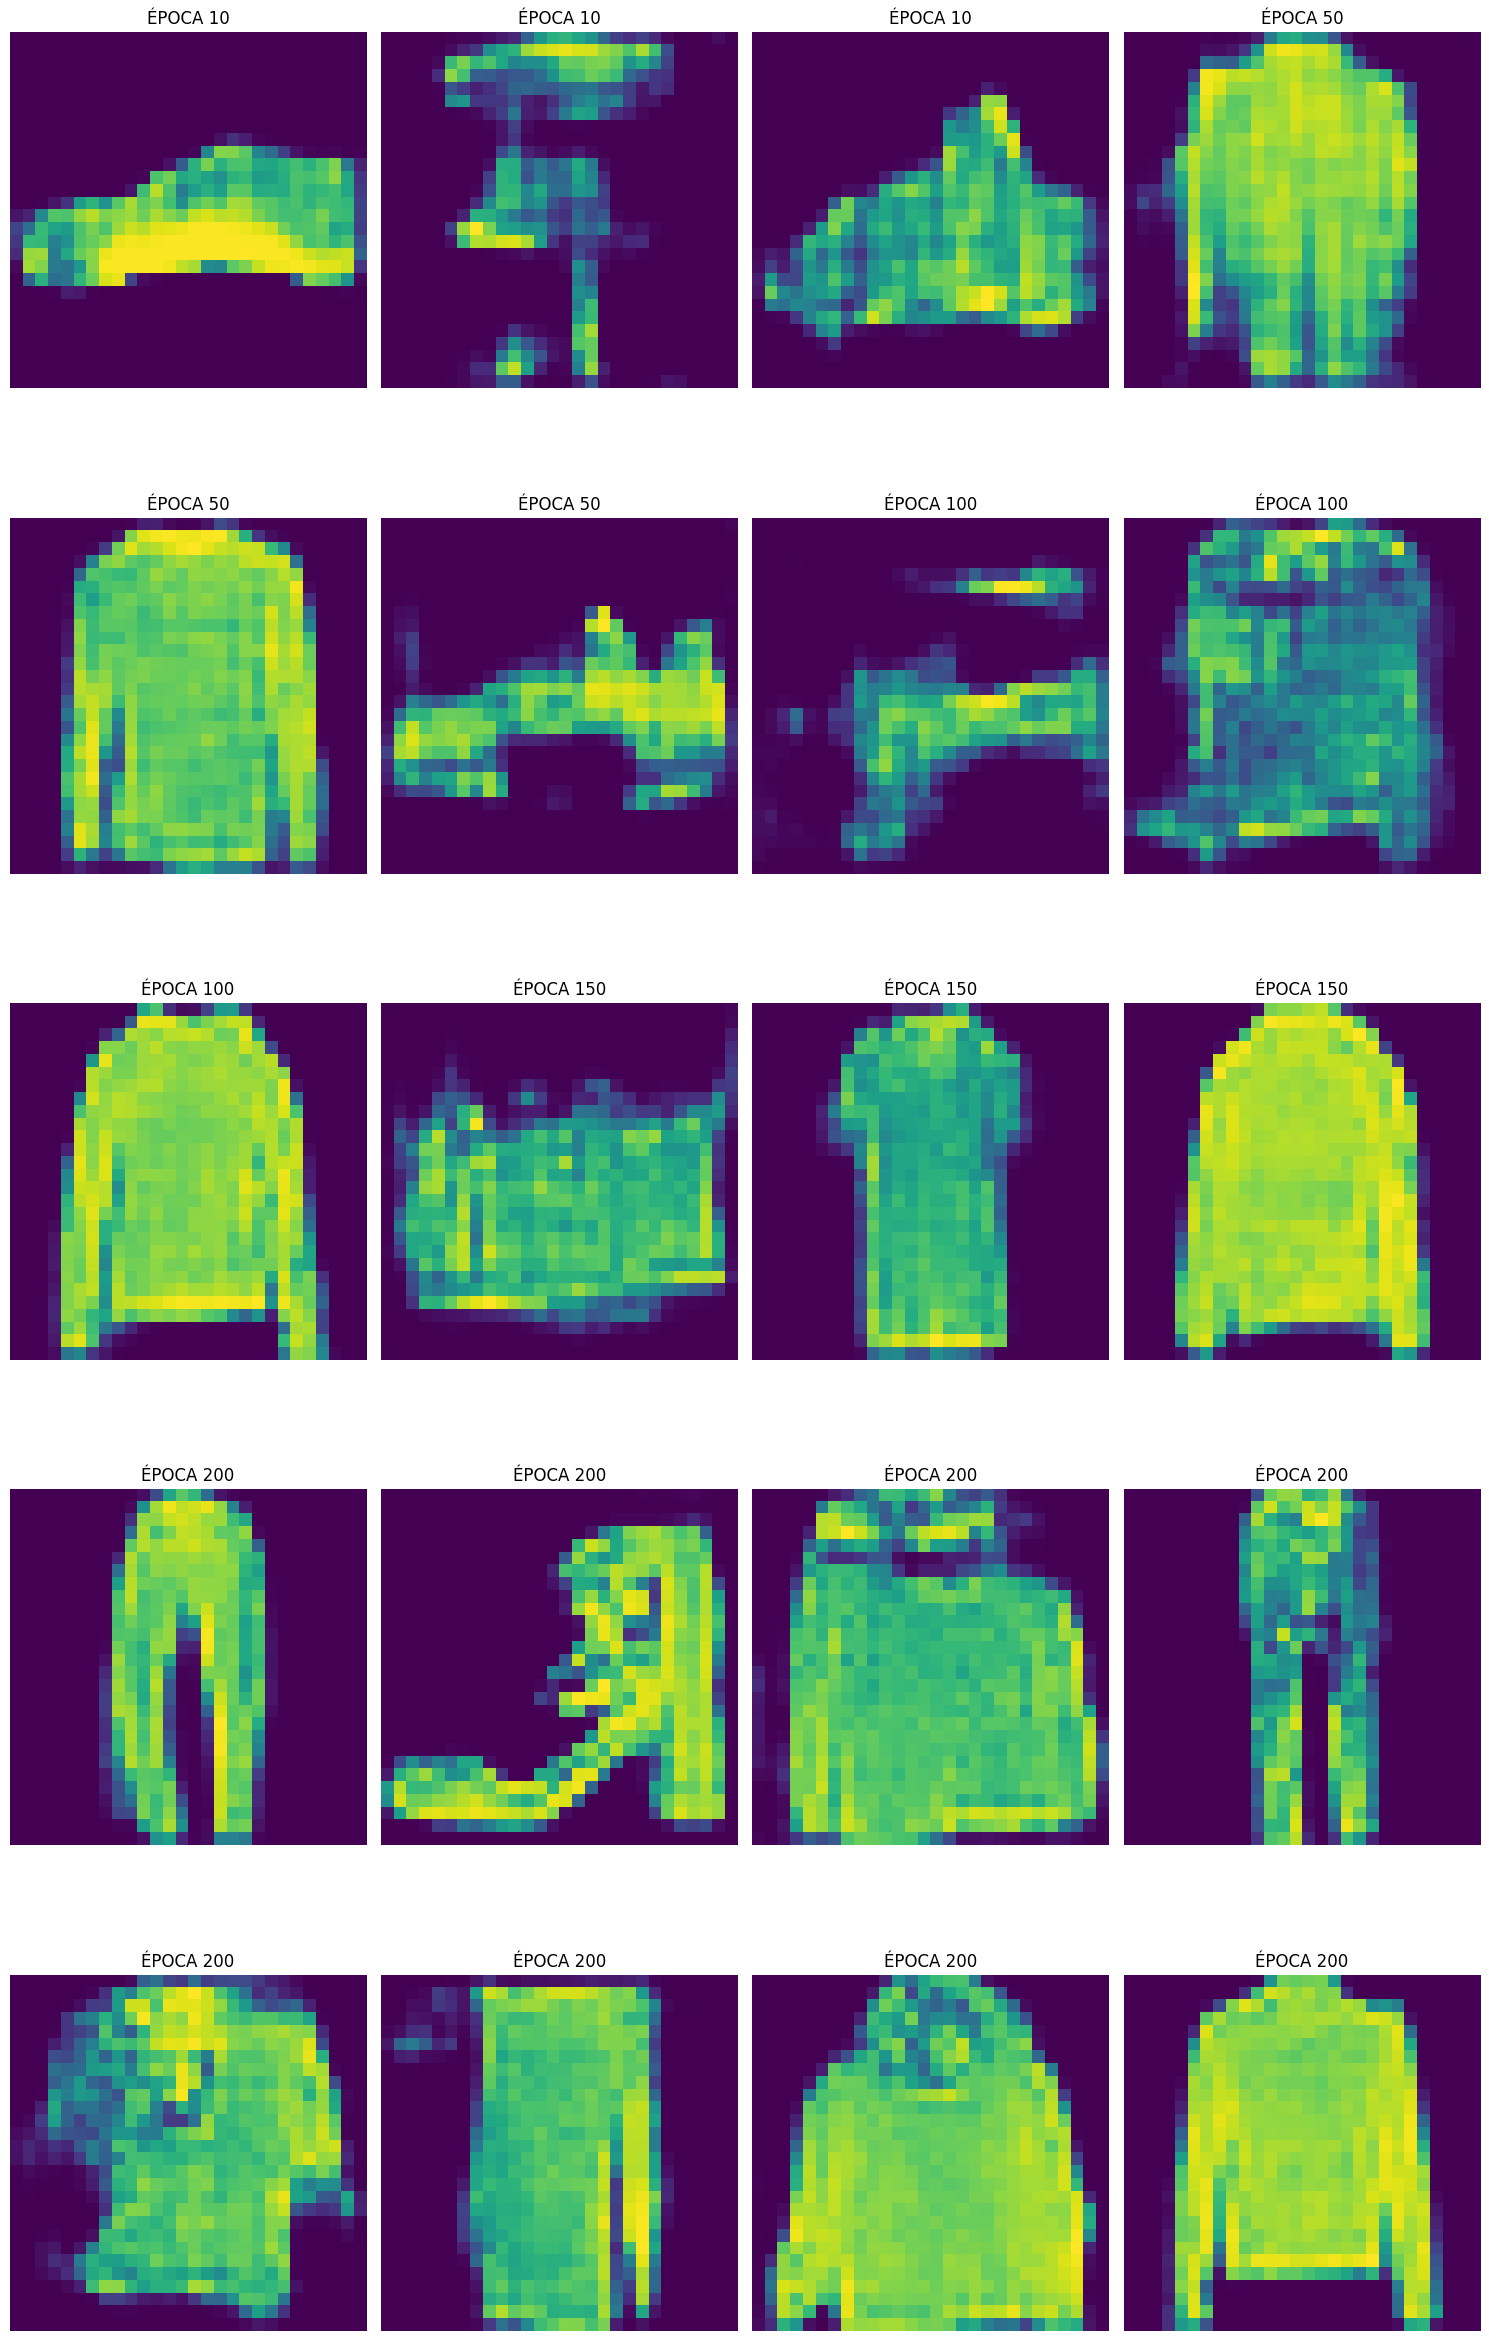

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

image_paths = [
    '/kaggle/working/resultados/generated_img_9_0.png',
    '/kaggle/working/resultados/generated_img_9_1.png',
    '/kaggle/working/resultados/generated_img_9_2.png',
    '/kaggle/working/resultados/generated_img_9_3.png',
    '/kaggle/working/resultados/generated_img_49_0.png',
    '/kaggle/working/resultados/generated_img_49_1.png',
    '/kaggle/working/resultados/generated_img_49_2.png',
    '/kaggle/working/resultados/generated_img_49_3.png',
    '/kaggle/working/resultados/generated_img_99_0.png',
    '/kaggle/working/resultados/generated_img_99_1.png',
    '/kaggle/working/resultados/generated_img_99_2.png',
    '/kaggle/working/resultados/generated_img_99_3.png',
    '/kaggle/working/resultados/generated_img_149_0.png',
    '/kaggle/working/resultados/generated_img_149_1.png',
    '/kaggle/working/resultados/generated_img_149_2.png',
    '/kaggle/working/resultados/generated_img_149_3.png',
    '/kaggle/working/resultados/generated_img_199_0.png',
    '/kaggle/working/resultados/generated_img_199_1.png',
    '/kaggle/working/resultados/generated_img_199_2.png',
    '/kaggle/working/resultados/generated_img_199_3.png',
]


num_images = len(image_paths)

num_cols = 4
num_rows = (num_images + num_cols - 1) // num_cols  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, image_path in enumerate(image_paths):
    try:
        img = Image.open(image_path)
        axes[i].imshow(img)
        axes[i].axis('off') 
        if i < 3:
            axes[i].set_title('ÉPOCA 10')  
        elif i < 6:
            axes[i].set_title('ÉPOCA 50')  
        elif i <9:
            axes[i].set_title('ÉPOCA 100')
        elif i<12:
            axes[i].set_title('ÉPOCA 150')
        else:
            axes[i].set_title('ÉPOCA 200')
    except Exception as e:
        print(f"Error cargando la imagen {image_path}: {e}")

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()

plt.show()
